In [1]:
# This code is adapted from: https://github.com/EveryWhereLab/camera-calibration-using-opencv-python

from matplotlib import pyplot as plt
import numpy as np
import cv2 as cv
import glob
import yaml

In [2]:
images = glob.glob('./cam3_images/.jpg')

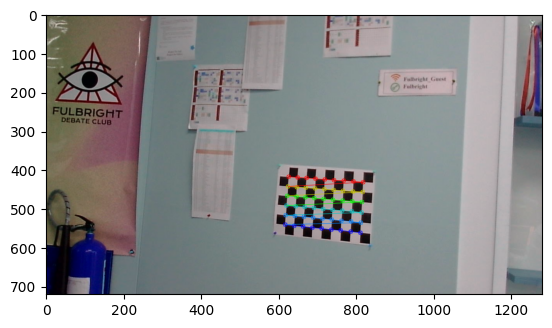

In [3]:
CHESSBOARD_CORNER_NUM_X = 9
CHESSBOARD_CORNER_NUM_Y = 6
CAMERA_PARAMETERS_OUTPUT_FILE = "cam1.yaml"

# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
objp = np.zeros((CHESSBOARD_CORNER_NUM_X*CHESSBOARD_CORNER_NUM_Y,3), np.float32)
objp[:,:2] = np.mgrid[0:CHESSBOARD_CORNER_NUM_X,0:CHESSBOARD_CORNER_NUM_Y].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (CHESSBOARD_CORNER_NUM_X,CHESSBOARD_CORNER_NUM_Y), None)
    
    # # Define the corners
    # BR_corner = corners[0, 0]
    # BL_corner = corners[8, 0]
    # TR_corner = corners[45, 0]
    # TL_corner = corners[53, 0]
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)
        # Draw and display the corners
        cv.drawChessboardCorners(img, (CHESSBOARD_CORNER_NUM_X,CHESSBOARD_CORNER_NUM_Y), corners2, ret)
        # Draw 4 outer corners
        # cv.circle(img, tuple(map(int, BR_corner)), 10, (0, 255, 0), -1)
        # cv.circle(img, tuple(map(int, BL_corner)), 10, (0, 255, 0), -1)
        # cv.circle(img, tuple(map(int, TR_corner)), 10, (0, 255, 0), -1)
        # cv.circle(img, tuple(map(int, TL_corner)), 10, (0, 255, 0), -1)
        # cv.line(img, tuple(map(int, BR_corner)), tuple(map(int, TR_corner)), (0,255,0), 2)
        # cv.line(img, tuple(map(int, BL_corner)), tuple(map(int, TL_corner)), (0,255,0), 2)
        # cv.line(img, tuple(map(int, BR_corner)), tuple(map(int, BL_corner)), (0,255,0), 2)
        # cv.line(img, tuple(map(int, TR_corner)), tuple(map(int, TL_corner)), (0,255,0), 2)
        plt.imshow(img)

    else:
        print('Failed to find a chessboard in {}'.format(fname))

Convert the focal length to mm

In [4]:
# Return the camera matrix
ret, camMatrix, distortionCoeff, rotationVectors, translationVectors = cv.calibrateCamera(
    objpoints, imgpoints, gray.shape[::-1], None, None)
# Displaying required output
print("\nCamera matrix:\n", camMatrix)
print("\nDistortion Parameters:\n", distortionCoeff)
# print("\nRotation Vectors:\n", rotationVectors)
# print("\nTranslation Vectors:\n", translationVectors)


Camera matrix:
 [[698.97194286   0.         665.75864171]
 [  0.         705.45718088 291.82145143]
 [  0.           0.           1.        ]]

Distortion Parameters:
 [[ 0.3748688  -2.03848565 -0.0233734  -0.03242466  4.29480138]]


In [5]:
fx_pix = int(camMatrix[0][0])
fy_pix = int(camMatrix[1][1])

print("fx in pixel: ", fx_pix)
print("fy in pixel: ", fy_pix)

img_h, img_w, channel = img.shape

sensor_width = 3.58

fx_mm = fx_pix * sensor_width / img_w
fy_mm = fy_pix * sensor_width / img_w

print("fx in mm: ", round(fx_mm,2))
print("fy in mm: ", round(fy_mm,2))

fx in pixel:  698
fy in pixel:  705
fx in mm:  1.95
fy in mm:  1.97


In [6]:
# Define the camera matrix
P = np.array([[381.04629625, 0, 327.53224381, 0],
              [0, 383.92432251, 281.0140685, 0],
              [0, 0, 1, 0]])

# Extract the rotation matrix R and translation vector t
K, R, t = cv.decomposeProjectionMatrix(P)[:3]

print("K", K)
print("R", R)
print("T", t)

t_f = t[1:]
# Compute the camera center coordinate in the world coordinate system
C = -np.linalg.inv(R) @ t_f

# # Convert the camera center coordinate into homogeneous coordinates
# C_h = np.append(C, 1)

# Transform the camera center coordinate into camera coordinates
C_c = np.linalg.inv(R) @ C

# Project the camera center coordinate onto the image plane
p = K @ C_c

# Convert the projected point to Cartesian coordinates
x, y = p[:2] / p[2]

# Print the center point of the camera in the image plane
print("Center point of camera in image plane:", x, y)


K [[381.04629625   0.         327.53224381]
 [  0.         383.92432251 281.0140685 ]
 [  0.           0.           1.        ]]
R [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
T [[0.]
 [0.]
 [0.]
 [1.]]
Center point of camera in image plane: [327.53224381] [281.0140685]


Produce Undistorted Images

In [7]:
for fname in images:
    img = cv.imread(fname)
    cropped = img[380:620, 550:850]
    gray = cv.cvtColor(cropped, cv.COLOR_BGR2GRAY)
    
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (CHESSBOARD_CORNER_NUM_X,CHESSBOARD_CORNER_NUM_Y), None)
    
    if ret == True:
        h, w = cropped.shape[:2]
        newCamMatrix, roi = cv.getOptimalNewCameraMatrix(camMatrix, distortionCoeff, (w,h), 1, (w,h))

        # Apply the remapping to undistort the image
        mapx, mapy = cv.initUndistortRectifyMap(camMatrix, distortionCoeff, None, newCamMatrix, (w, h), 5)
        dst = cv.remap(cropped, mapx, mapy, cv.INTER_LINEAR)
        cv.imwrite('caliResult.png', dst)


Connect the chessboard corners

In [8]:
caliImg = cv.imread('caliResult.png')
caliGray = cv.cvtColor(caliImg, cv.COLOR_BGR2GRAY)

# Find the chess board corners
ret, corners = cv.findChessboardCorners(caliGray, (CHESSBOARD_CORNER_NUM_X,CHESSBOARD_CORNER_NUM_Y), None)

# # Define the corners
# BR_corner = corners[0, 0]
# BL_corner = corners[8, 0]
# TR_corner = corners[45, 0]
# TL_corner = corners[53, 0]

corners2 = cv.cornerSubPix(caliGray,corners, (11,11), (-1,-1), criteria)
# Draw and display the corners
cv.drawChessboardCorners(caliImg, (CHESSBOARD_CORNER_NUM_X,CHESSBOARD_CORNER_NUM_Y), corners2, ret)
# Draw 4 outer corners
# cv.circle(caliImg, tuple(map(int, BR_corner)), 10, (0, 255, 0), -1)
# cv.circle(caliImg, tuple(map(int, BL_corner)), 10, (0, 255, 0), -1)
# cv.circle(caliImg, tuple(map(int, TR_corner)), 10, (0, 255, 0), -1)
# cv.circle(caliImg, tuple(map(int, TL_corner)), 10, (0, 255, 0), -1)


# cv.line(caliImg, tuple(map(int, BR_corner)), tuple(map(int, TR_corner)), (0,255,0), 2)
# cv.line(caliImg, tuple(map(int, BL_corner)), tuple(map(int, TL_corner)), (0,255,0), 2)
# cv.line(caliImg, tuple(map(int, BR_corner)), tuple(map(int, BL_corner)), (0,255,0), 2)
# cv.line(caliImg, tuple(map(int, TR_corner)), tuple(map(int, TL_corner)), (0,255,0), 2)      
plt.imshow(caliImg)


error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\cornersubpix.cpp:58: error: (-215:Assertion failed) count >= 0 in function 'cv::cornerSubPix'
